In [1]:
import pandas as pd
import numpy as np
import os
os.chdir('/home/kruu/git_folder/eye_tracking/')

from utils.data_processing import EyeTrackingProcessor

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

****
# Data Processing
****

In [2]:
data_path = "/store/kruu/eye_tracking"
files_list = os.listdir(data_path)
files_list = [os.path.join(data_path, file) for file in files_list]

tasks = ['Task 1', 'Task 2', 'Task 3', 'Task 4', 'Task 5', 'Task 6']
features = ['Recording timestamp', 'Gaze point X', 'Gaze point Y', 'Mouse position X', 'Mouse position Y', 'Participant name']
interpolate_col = ['Gaze point X', 'Gaze point Y', 'Mouse position X', 'Mouse position Y']

processor = EyeTrackingProcessor()
all_data = processor.load_data(files_list)
dataset = processor.get_features(all_data, tasks, features)

#Fixed Time step resampling
dataset_resampled = processor.fixed_time_steps_resample(dataset, interpolate_col, timestep = 0.01, pad_value = np.nan)
dataset_resampled["sample_id"] = dataset_resampled.groupby(["Participant name", "Task_id", "Task_execution"]).ngroup()
dataset_resampled["sample_id"] = dataset_resampled["sample_id"].astype(str)

#Chunk per task
# dataset_chunked = processor.get_chunks(dataset, chunk_duration=5*1e6, time_offset_chunk=0.5*1e6)
# dataset_chunked_resampled = processor.fixed_length_resample(dataset_chunked, interpolate_col, target_size=600)

/home/kruu/git_folder/eye_tracking/utils/data_processing.py:19: DtypeWarning: Columns (76) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep='\t')
/home/kruu/git_folder/eye_tracking/utils/data_processing.py:19: DtypeWarning: Columns (76) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep='\t')


****
# Full task
****

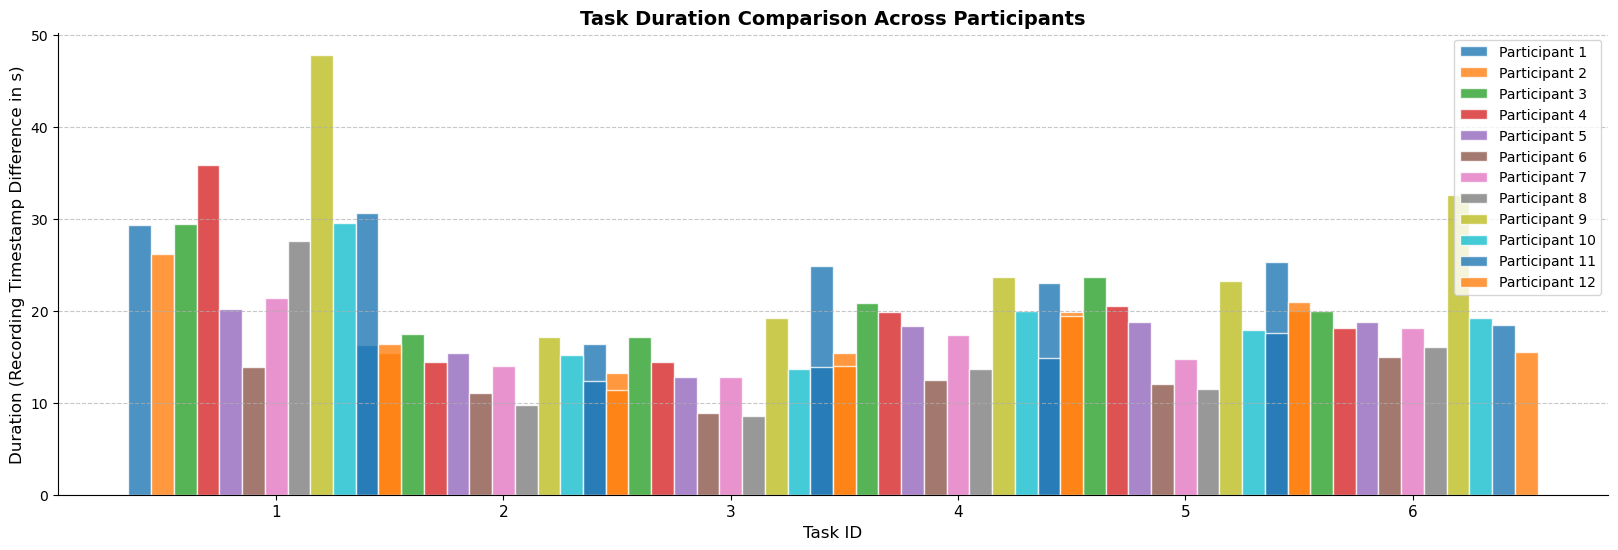

In [3]:
import matplotlib.colors as mcolors

durations = pd.DataFrame(dataset_resampled.groupby(['Participant name', 'Task_id', 'Task_execution'])['Recording timestamp'].agg(lambda x: (x.max() - x.min())/1e6).reset_index().groupby(['Participant name', 'Task_id'])['Recording timestamp'].mean()).reset_index()

plt.figure(figsize=(20, 6))
pastel_colors = list(mcolors.TABLEAU_COLORS.values())
bar_width = 0.1
task_ids = sorted(durations["Task_id"].unique())
participants = sorted(durations["Participant name"].unique())
x_indexes = np.arange(len(task_ids))

# Plot bars for each participant
for i, participant in enumerate(participants):
    participant_data = durations[durations["Participant name"] == participant]
    plt.bar(x_indexes + i * bar_width, participant_data["Recording timestamp"], 
            width=bar_width, color=pastel_colors[i % len(pastel_colors)], 
            edgecolor='white', alpha=0.8, label=f'Participant {participant}')

# Formatting
plt.xlabel("Task ID", fontsize=12)
plt.ylabel("Duration (Recording Timestamp Difference in s)", fontsize=12)
plt.title("Task Duration Comparison Across Participants", fontsize=14, fontweight='bold')

plt.xticks(x_indexes + (bar_width * (len(participants) / 2)), task_ids, fontsize=11) 

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.legend(fontsize=10)

plt.show()


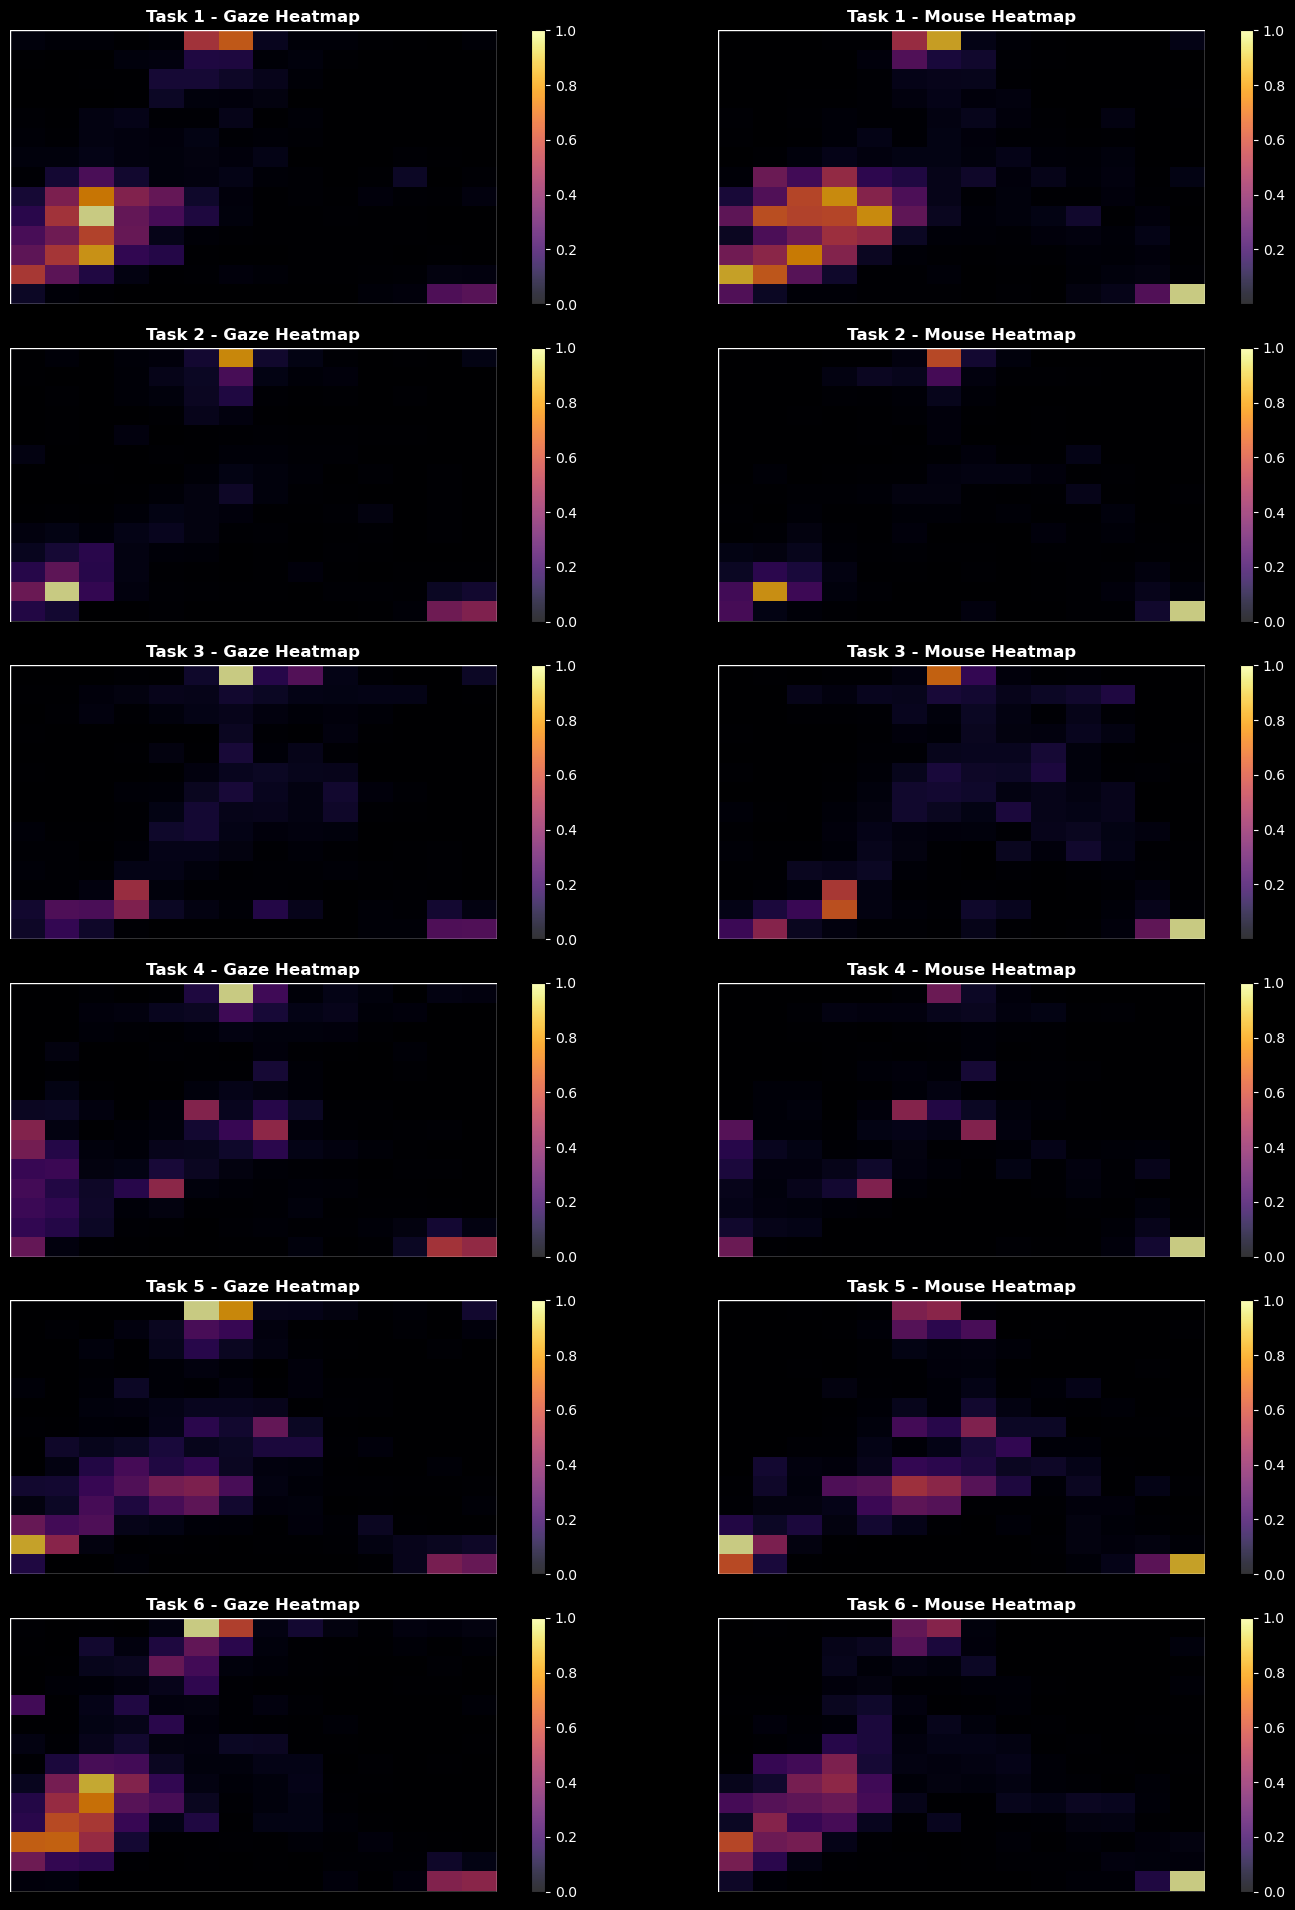

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

screen_width = 1920
screen_height = 1080
bins = 15
fig, axes = plt.subplots(6, 2, figsize=(18, 20))  # Increased height for better spacing

for i in range(0, 6): 
    plot_df = dataset_resampled.query(f"Task_id == {i+1}")
    gaze_x, gaze_y = plot_df["Gaze point X"], plot_df["Gaze point Y"]
    mouse_x, mouse_y = plot_df["Mouse position X"], plot_df["Mouse position Y"]

    bins_x = np.linspace(0, screen_width, bins)
    bins_y = np.linspace(0, screen_height, bins)
    heatmap_gaze, _, _ = np.histogram2d(gaze_x, gaze_y, bins=[bins_x, bins_y])
    heatmap_mouse, _, _ = np.histogram2d(mouse_x, mouse_y, bins=[bins_x, bins_y])

    # Normalize heatmaps for better visualization
    if np.max(heatmap_gaze) > 0:
        heatmap_gaze = heatmap_gaze / np.max(heatmap_gaze)
    if np.max(heatmap_mouse) > 0:
        heatmap_mouse = heatmap_mouse / np.max(heatmap_mouse)


    ax1, ax2 = axes[i, 0], axes[i, 1]
    
    # Gaze Heatmap
    im1 = ax1.imshow(heatmap_gaze.T, extent=[0, screen_width, 0, screen_height], 
                     origin="lower", cmap="inferno", alpha=0.8)
    ax1.add_patch(plt.Rectangle((0, 0), screen_width, screen_height, fill=None, color='white', linewidth=1))
    ax1.set_title(f"Task {i+1} - Gaze Heatmap", fontsize=12, fontweight="bold", color="white")
    ax1.set_xlim(0, screen_width)
    ax1.set_ylim(0, screen_height)
    ax1.axis("off")

    cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
    cbar1.ax.tick_params(labelsize=10, colors="white")

    # Mouse Heatmap
    im2 = ax2.imshow(heatmap_mouse.T, extent=[0, screen_width, 0, screen_height], 
                     origin="lower", cmap="inferno", alpha=0.8)
    ax2.add_patch(plt.Rectangle((0, 0), screen_width, screen_height, fill=None, color='white', linewidth=1))
    ax2.set_title(f"Task {i+1} - Mouse Heatmap", fontsize=12, fontweight="bold", color="white")
    ax2.set_xlim(0, screen_width)
    ax2.set_ylim(0, screen_height)
    ax2.axis("off")

    cbar2 = fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
    cbar2.ax.tick_params(labelsize=10, colors="white")

# Improve layout
plt.tight_layout(rect=[0, 0, 0.90, 0.96])
fig.patch.set_facecolor('black') 
plt.show()


Similarities with Nino's work: 
 - Task extraction is consistant
 - Scaler are the same when fitted per feature
 - Rescaling the stime steps doesn't change de scaler bounds.

Discrepancies with Nino's work: 
 - Scaler is fitted before flattening the dataset. I.e. we fit per feature and not per feature+timestamp (which is not a bad idea) -> Scaling before or after doesn't change that much to tbh
 - He didn't rescale to constant time steps accross the observations. Only to constant sizes trough padding
 - THe shape of his training dataset is 1728 * 10304 whereas mine is 432 * 363372

The discrepancies in the sizes is because Nino both concatenated horizontally the features for a same task, but also vertically. 

In [5]:
# Projection of time series in a 2D space using PCA

def flatten_group(group):
    return np.concatenate([
        group['Gaze point X'].values,
        group['Gaze point Y'].values,
        group['Mouse position X'].values,
        group['Mouse position Y'].values,
    ])

# Grouping by participant, task, execution
# X_proj and y_proj should be ordered the same way accorgin sample id
X_proj = np.vstack(dataset_resampled.groupby(["sample_id"]).apply(flatten_group))
y_proj = dataset_resampled.groupby(["sample_id"])["Task_id"].min().values

/tmp/ipykernel_1863041/4186782209.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  X_proj = np.vstack(dataset_resampled.groupby(["sample_id"]).apply(flatten_group))


[0.4415327  0.16043632 0.08055693 0.04747298 0.03409743]


/tmp/ipykernel_1863041/3298771369.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


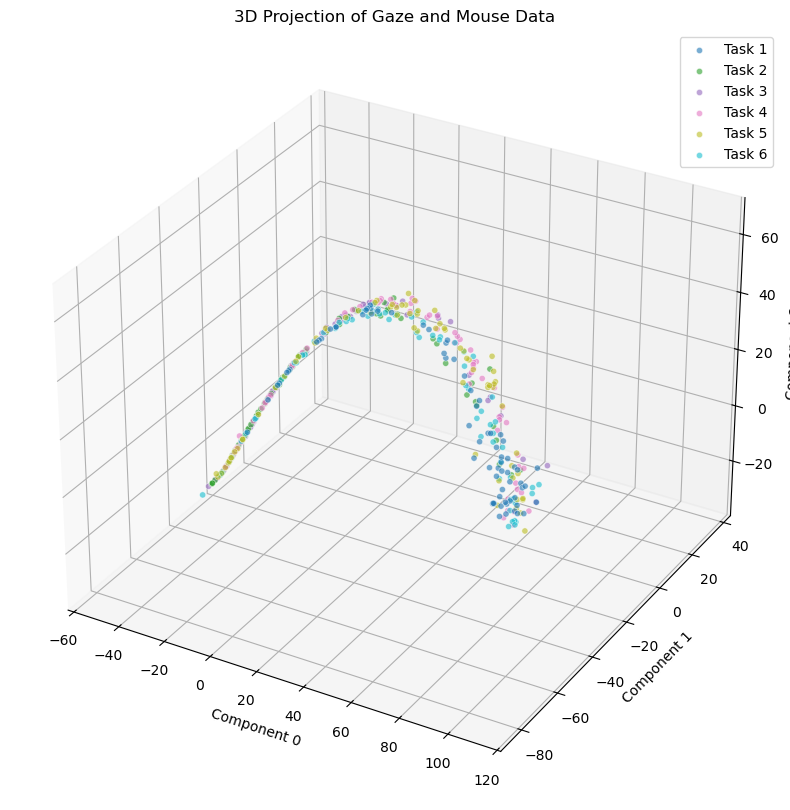

In [6]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

scaler_proj = MinMaxScaler()
X_proj_scaled = scaler_proj.fit_transform(X_proj)

# Putting -1 to nan values for padding and out of screen (if applied)
X_proj_scaled = np.where(np.isnan(X_proj_scaled), -1, X_proj_scaled)

# tsne = TSNE(n_components=3, random_state=0)
# embeddings = tsne.fit_transform(X_proj_scaled)

pca = PCA(n_components=5)
embeddings = pca.fit_transform(X_proj_scaled)
print(pca.explained_variance_ratio_)

# Create a color map for labels
unique_labels = np.unique(y_proj)
colors = plt.cm.get_cmap('tab10', len(unique_labels))

fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')

unique_labels = np.unique(y_proj)
for i, label in enumerate(unique_labels):
    indices = y_proj == label
    ax.scatter(embeddings[indices, 0], embeddings[indices, 1], embeddings[indices, 2],
               color=colors(i), label=f'Task {label}', alpha=0.6, edgecolors='w', linewidth=0.5)

ax.set_title('3D Projection of Gaze and Mouse Data')
ax.set_xlabel('Component 0')
ax.set_ylabel('Component 1')
ax.set_zlabel('Component 2')
ax.legend()
plt.show()

Features seem to be uterly correlated: Wether we take all the features or each feature separately, the projection through PCA give very close results.  It seems that all features can be explained very much with one of them. Eight we have a bug in the processing or we can only use one of them

TODO:
- Function that build a training dataset of size (nb_obs, nb_features, sequence len) instead of concatenating the last two sizes

****
# Correlation between features
****

In [7]:
# Pearson correlation of each sample
dataset_correlations = dataset_resampled.groupby('sample_id').apply(lambda g: g['Mouse position X'].corr(g['Gaze point X']))

/tmp/ipykernel_1863041/3222423598.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dataset_correlations = dataset_resampled.groupby('sample_id').apply(lambda g: g['Mouse position X'].corr(g['Gaze point X']))


In [8]:
dataset_correlations.abs().min().item(), dataset_correlations.abs().max().item(), dataset_correlations.abs().mean().item(),

(0.005522482572493211, 0.9835547944812852, 0.6942557121611959)

****
# Training on full tasks
****

In [9]:
placeholder_value = np.nan
# Identifying outside the screen seems to decrease the performance
# dataset_resampled = processor.outside_screen_placeholder(dataset_resampled, [-200, 2120], [-200, 1280], placeholder_value)

def flatten_group(group):
    return np.concatenate([
        group['Gaze point X'].values,
        group['Gaze point Y'].values,
        group['Mouse position X'].values,
        group['Mouse position Y'].values,
    ])

def stack_group(group):
    """
    Converts each time series group into a (n_features, seq_len) format
    instead of flattening it into a 1D vector.
    """
    return np.stack([
        group['Gaze point X'].values,
        group['Gaze point Y'].values,
        group['Mouse position X'].values,
        group['Mouse position Y'].values
    ], axis=0)

# Grouping by participant, task, execution
X = np.vstack(dataset_resampled.groupby(["sample_id"]).apply(flatten_group))
y = dataset_resampled.groupby(["sample_id"])["Task_id"].min().values

# Grouping by `sample_id`
X_stacked = np.array(dataset_resampled.groupby(["sample_id"]).apply(stack_group).tolist())
y_stacked = dataset_resampled.groupby(["sample_id"])["Task_id"].min().values

# Create a mask (1 for real values, 0 for padded values) -> For Deep Learning architectures
# train_mask = np.where(X_train_scaled == 0, 0, 1)
# test_mask = np.where(X_test_scaled == 0, 0, 1)

/tmp/ipykernel_1863041/2155593233.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  X = np.vstack(dataset_resampled.groupby(["sample_id"]).apply(flatten_group))
/tmp/ipykernel_1863041/2155593233.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  X_stacked = np.array(dataset_resampled.groupby(["sample_id"]).apply(stack_group).tolist())


### SVM

In [38]:
scaler = MinMaxScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Replace nans with -1 after scaling
X_train_scaled = np.where(np.isnan(X_train_scaled), 0, X_train_scaled)
X_test_scaled = np.where(np.isnan(X_test_scaled), 0, X_test_scaled)

# Define the hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],  # Kernel coefficient
    'kernel': ['rbf', 'linear']  # Kernel type
}

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
print(best_params)

# # Train SVM
svm_model = SVC(kernel=best_params["kernel"], C=best_params["C"], gamma=best_params["gamma"])
svm_model.fit(X_train_scaled, y_train)
y_pred = svm_model.predict(X_test_scaled)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(accuracy)
print(classification_rep)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
{'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
0.41379310344827586
              precision    recall  f1-score   support

           1       0.46      0.46      0.46        13
           2       0.43      0.60      0.50        10
           3       0.55      0.38      0.44        16
           4       0.70      0.32      0.44        22
           5       0.24      0.29      0.26        17
           6       0.33      0.67      0.44         9

    accuracy                           0.41        87
   macro avg       0.45      0.45      0.43        87
weighted avg       0.48      0.41      0.42        87



In [39]:
# Clear overfitting here
pred_train = svm_model.predict(X_train_scaled)
accuracy_score(y_train, pred_train)

1.0

### XGboost

In [21]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

scaler_xgb = MinMaxScaler()
X_train_scaled = scaler_xgb.fit_transform(X_train)
X_test_scaled = scaler_xgb.transform(X_test)

X_train_scaled = np.where(np.isnan(X_train_scaled), 0, X_train_scaled)
X_test_scaled = np.where(np.isnan(X_test_scaled), 0, X_test_scaled)

# Reduce overfitting by using projection first -> Doesn't work yet
# pca_xgb = PCA(n_components=5)
# embeddings_xgb = pca_xgb.fit_transform(X_train_scaled)
# print(pca_xgb.explained_variance_ratio_)

# Shift labels to start from 0
y_train_shifted = y_train - 1
y_test_shifted = y_test - 1

# Define sensible XGBoost hyperparameters
xgb_model = xgb.XGBClassifier(
    n_estimators=200,        # Number of boosting rounds (trees)
    max_depth=6,             # Moderate tree depth
    learning_rate=0.1,       # Standard learning rate
    subsample=0.8,           # Use 80% of the data per tree
    colsample_bytree=0.8,    # Use 80% of the features per tree
    gamma=0.1,               # Small loss reduction threshold
    use_label_encoder=False,  # Avoid warnings
    eval_metric='logloss',    # Log loss as evaluation metric
    random_state=42
)

# Train the model
xgb_model.fit(X_train_scaled, y_train_shifted)

# Make predictions
y_pred = xgb_model.predict(X_test_scaled)

# Evaluate performance
accuracy = accuracy_score(y_test_shifted, y_pred)
classification_rep = classification_report(y_test_shifted, y_pred)

print(f"Test Accuracy: {accuracy:.4f}")
print(classification_rep)

/home/kruu/.conda/envs/aware/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [10:51:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Accuracy: 0.4943
              precision    recall  f1-score   support

           0       0.57      0.31      0.40        13
           1       0.55      0.60      0.57        10
           2       0.37      0.44      0.40        16
           3       0.65      0.50      0.56        22
           4       0.47      0.41      0.44        17
           5       0.44      0.89      0.59         9

    accuracy                           0.49        87
   macro avg       0.51      0.52      0.49        87
weighted avg       0.52      0.49      0.49        87



In [23]:
pred_train = xgb_model.predict(X_train_scaled)
accuracy_score(y_train_shifted, pred_train)

1.0

Idea: perform somehow a transfer learning:
- Find an algorithm that manages efficiently to classify the time series. We can say that the feature extraction works with that.
- Use the same feature extractor on chunks of data and seen if it's possible to classify them as well. 
- The resampling with chunks of the same duration is alright. But when dealing with the full ts that have different durations, we cannot resample them at the same rate because then the temporality is not respected. Ideas to deal with that: 
    - Using a regural time parameterisation and then using padding to account for different lengths
    - Not bothering about the time and representing the gaze and mouse data as images (heatmaps), and classifying them with knn. Nice but then it's hard to do some transfer learning with temporal data with the chunks. 

****
# Chunk comparison
***

In [ ]:
# Verification of chunk durations
# Some full tasks are lower than the chunk duration
test = dataset_chunked.groupby(['Participant name', 'Task_id', 'Task_execution', 'chunk_id'])["Recording timestamp"].agg(lambda x: (x.max() - x.min())/1e6)
test.describe()

In [ ]:
dataset_chunked_resampled.isna().sum()

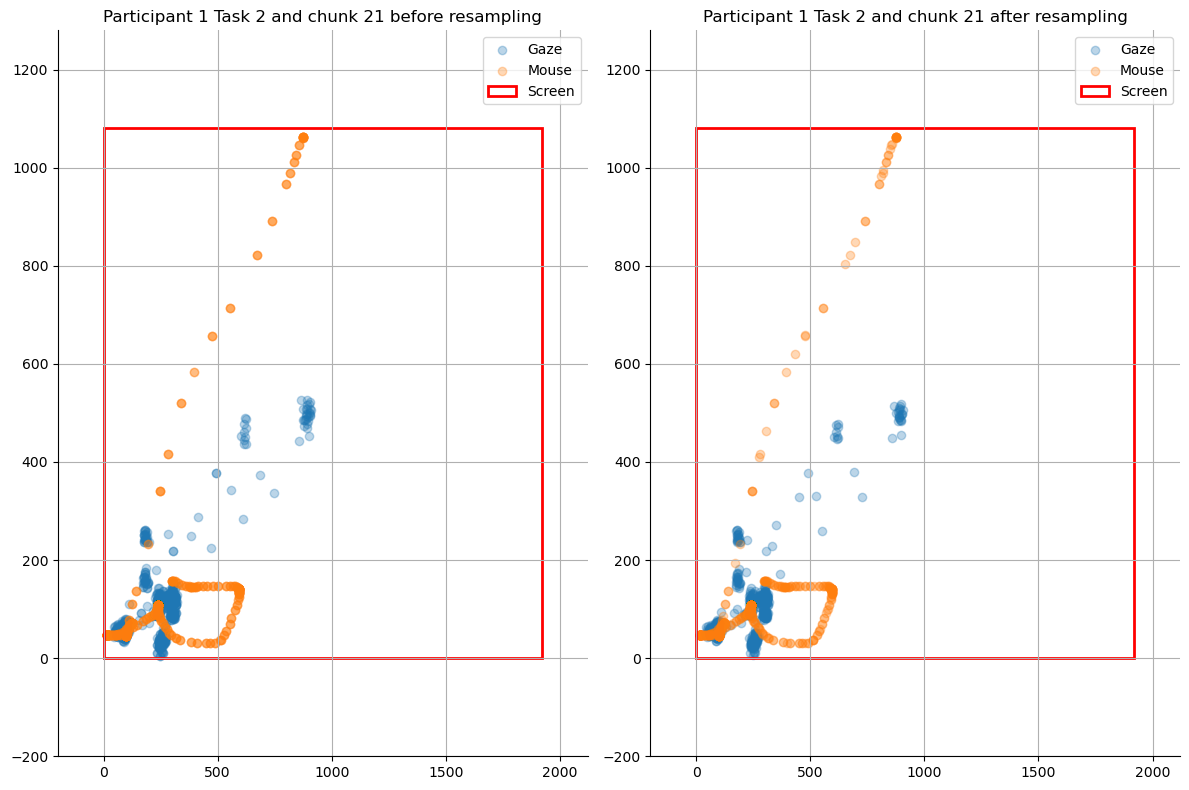

In [9]:
# Comparision of chunks before and after resampling
participant = np.random.choice(dataset_chunked["Participant name"].unique())
task_id = np.random.choice(dataset_chunked["Task_id"].unique())
task_execution = np.random.choice(dataset_chunked["Task_execution"].unique())
data_plot = dataset_chunked.query(f"`Participant name` == {participant} and Task_id == {task_id} and Task_execution == {task_execution}")
chunk_id = np.random.choice(data_plot["chunk_id"].dropna().unique())
data_plot_initial = data_plot.query(f"chunk_id == {chunk_id}")
data_plot_resampled = dataset_chunked_resampled.query(f"`Participant name` == {participant} and Task_id == {task_id} and Task_execution == {task_execution} and chunk_id == {chunk_id}")

fig, axes = plt.subplots(1, 2, figsize=(12, 8)) 
axes = axes.flatten()
axes[0].scatter(data_plot_initial["Gaze point X"], data_plot_initial["Gaze point Y"], label="Gaze", alpha=0.3)
axes[0].scatter(data_plot_initial["Mouse position X"], data_plot_initial["Mouse position Y"], label="Mouse", alpha=0.3)
axes[0].set_title(f"Participant {participant} Task {task_id} and chunk {chunk_id} before resampling")
axes[0].add_patch(plt.Rectangle((0, 0), 1920, 1080, fill=None, color='r', linewidth=2, label="Screen"))
axes[0].legend()
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].grid(True)
axes[0].set_xlim(-200, 2120)
axes[0].set_ylim(-200, 1280)

axes[1].scatter(data_plot_resampled["Gaze point X"], data_plot_resampled["Gaze point Y"], label="Gaze", alpha=0.3)
axes[1].scatter(data_plot_resampled["Mouse position X"], data_plot_resampled["Mouse position Y"], label="Mouse", alpha=0.3)
axes[1].set_title(f"Participant {participant} Task {task_id} and chunk {chunk_id} after resampling")
axes[1].add_patch(plt.Rectangle((0, 0), 1920, 1080, fill=None, color='r', linewidth=2, label="Screen"))
axes[1].legend()
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].grid(True)
axes[1].set_xlim(-200, 2120)
axes[1].set_ylim(-200, 1280)


plt.tight_layout()
plt.show()

****
# Model Training
****

First idea:
- One sample is 600 observations, for one participant, one task, and one chunk_id
- Label is task_id
- First we will work on aggregated features like min/max/mean/std to see if they are sufficient to predict. If not we will use the full time series and train an LSTM of whatever. 
- Try using multi-head 2D CNN: one for gazeX/Y and another one for MouseX/Y

In [ ]:
#If the gaze or mouse is outside the screen, we replace the value with nan
placeholder_value = np.nan
train_dataset = processor.outside_screen_placeholder(dataset_chunked_resampled, [-200, 2120], [-200, 1280], placeholder_value)

# We can add a missingness Indicator Feature
# for col in features:
#     dataset[col + "_missing"] = (dataset[col] == placeholder_value).astype(int)

In [9]:
def flatten_group(group):
    return np.concatenate([
        group['Gaze point X'].values,
        group['Gaze point Y'].values,
        group['Mouse position X'].values,
        group['Mouse position Y'].values
    ])

# Grouping by participant, task, execution, and chunk
grouped_data = train_dataset.groupby(['Participant name', 'Task_id', 'Task_execution', 'chunk_id']).apply(flatten_group)

# Flatten column names after aggregation
flattened_df = grouped_data.reset_index()
flattened_df.columns = ['Participant name', 'Task_id', 'Task_execution', 'chunk_id', 'flattened_features']

# Extract features (X) and labels (y)
X = np.vstack(flattened_df['flattened_features'].values)
y = flattened_df['Task_id'].values

# Train/test split (WARNING: split before if using time series data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/tmp/ipykernel_152864/3585948980.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_data = train_dataset.groupby(['Participant name', 'Task_id', 'Task_execution', 'chunk_id']).apply(flatten_group)


In [10]:
scaler = MinMaxScaler()

# MinMaxScaler automatically keep nans out of scaling
# We can also set ourselves the values of MinMax with the screen limits
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Replace nans with -1 after scaling: they are indicating outside of the screen
X_train_scaled = np.where(np.isnan(X_train_scaled), -1, X_train_scaled)
X_test_scaled = np.where(np.isnan(X_test_scaled), -1, X_test_scaled)


In [12]:
# # Define the hyperparameter grid
# param_grid = {
#     'C': [0.1, 1, 10, 100],  # Regularization parameter
#     'gamma': ['scale', 'auto', 0.01, 0.1, 1],  # Kernel coefficient
#     'kernel': ['rbf', 'linear']  # Kernel type
# }

# # Perform Grid Search with cross-validation
# grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
# grid_search.fit(X_train_scaled, y_train)

# # Get the best parameters and best score
# best_params = grid_search.best_params_
# print(best_params)

# Train SVM
# svm_model = SVC(kernel=best_params["kernel"], C=best_params["C"], gamma=best_params["gamma"])
svm_model = SVC(kernel="rbf", C=10, gamma="auto")
svm_model.fit(X_train_scaled, y_train)
y_pred = svm_model.predict(X_test_scaled)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(accuracy)
print(classification_rep)

0.40885072655217963
              precision    recall  f1-score   support

           1       0.39      0.74      0.51       411
           2       0.46      0.35      0.39       197
           3       0.48      0.28      0.35       155
           4       0.47      0.41      0.44       240
           5       0.34      0.26      0.29       229
           6       0.41      0.16      0.23       282

    accuracy                           0.41      1514
   macro avg       0.42      0.37      0.37      1514
weighted avg       0.42      0.41      0.38      1514



Ideas to implement:
- Maybe explore an algorithm that is based on the full task and try to recognise if what he is observing is a bit of the full task. 
- Find a way to represent the "average pattern" for each task and then build a model that recognise that each chunk is a part of this pattern -> Sub timeseries classification / pattern recognition in time series. 
- An idea could be as well to represent the average full task as an image, and we have to find out if the chunk is actually a sub image of the full task.
- Using images is not necessarily the best idea because we lose the information about the evolution of the gaze and the mouse. When plotting the raw images, they look all the same because in all tasks we the gaze and the mouse pretty much go through the whole screen.